In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from ast import literal_eval
from IPython import display

number of episodes finished 5178


<Figure size 432x288 with 0 Axes>

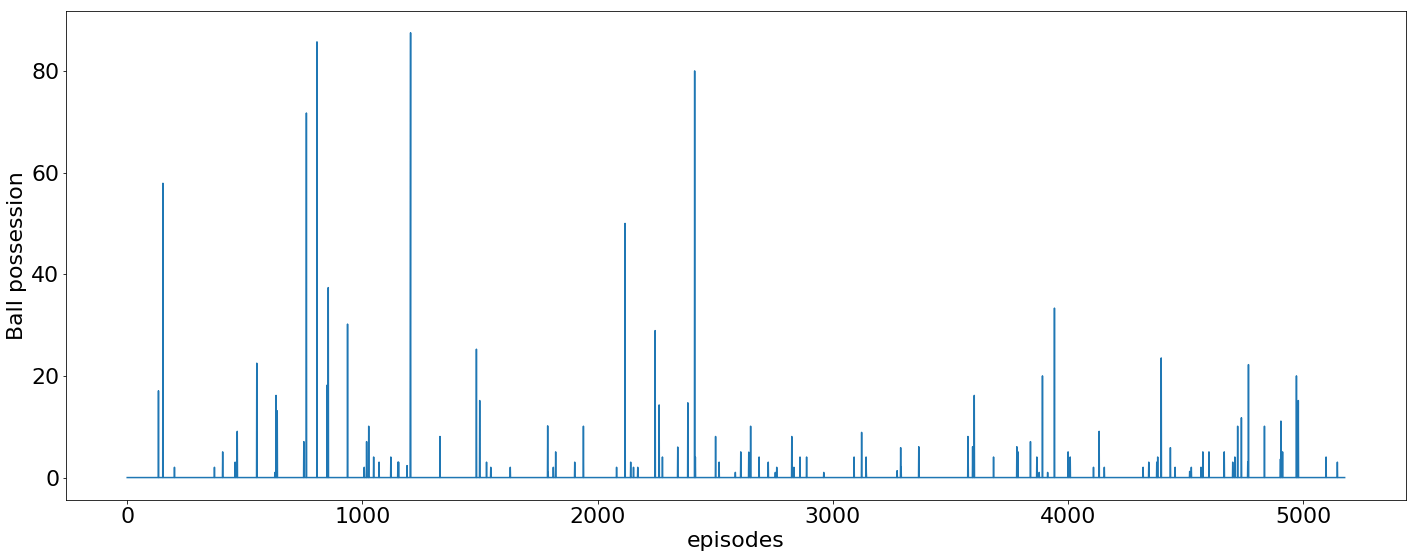

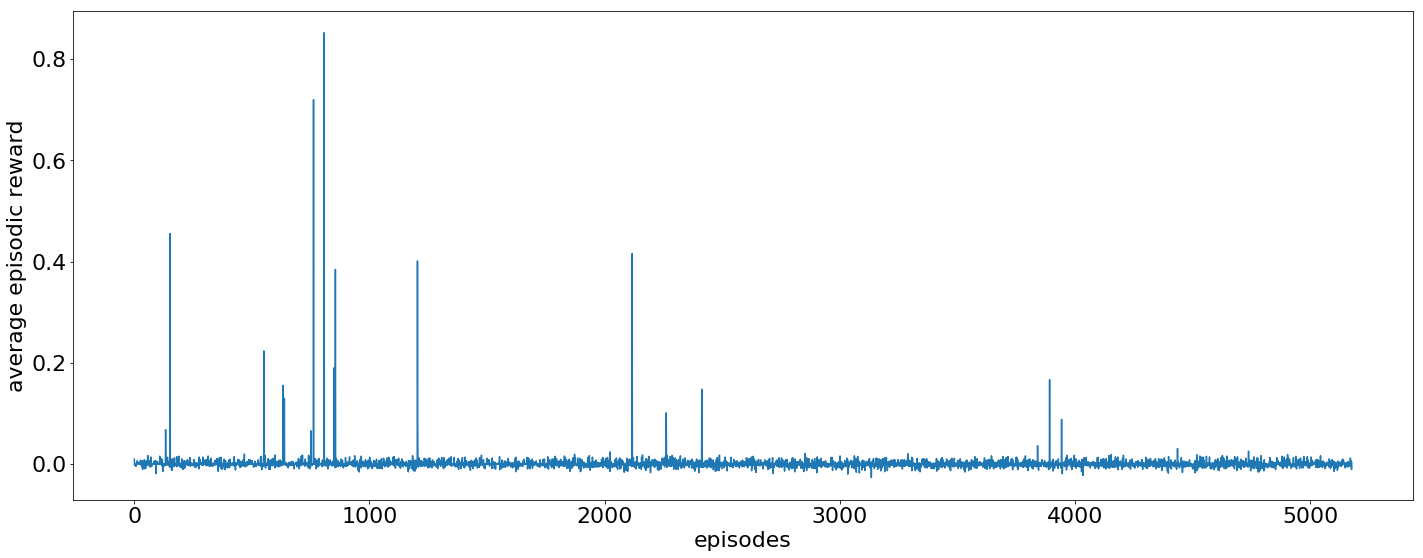

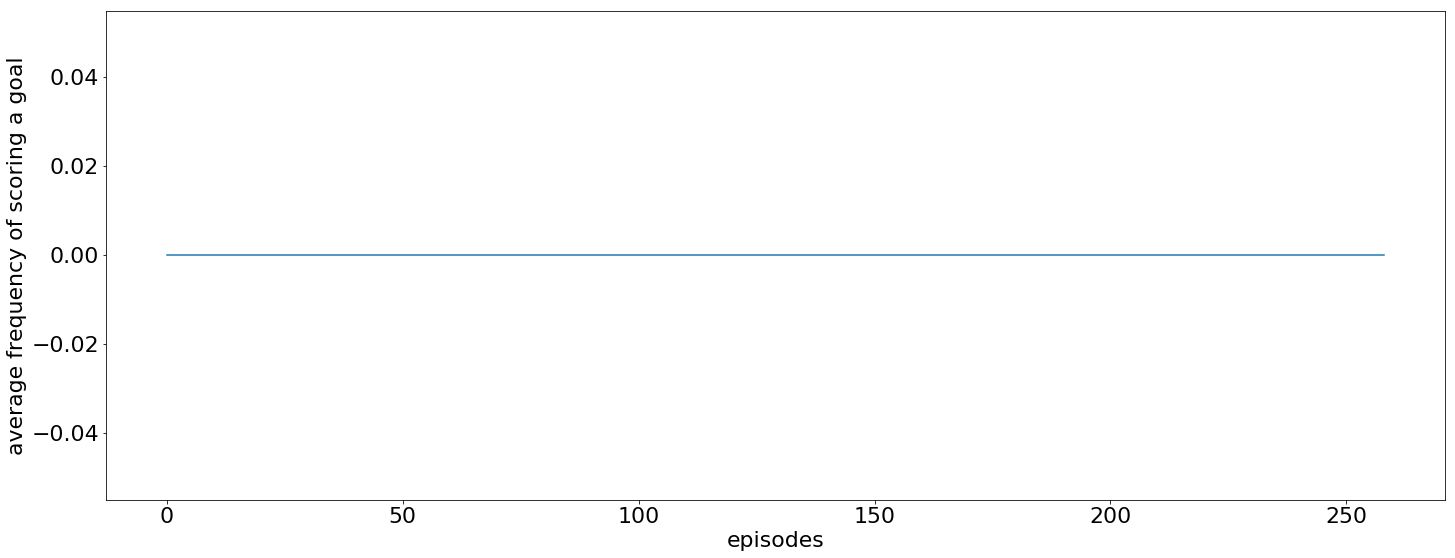

<Figure size 432x288 with 0 Axes>

In [ ]:
for repeat in range(100):
    try:
        goal_frequency_window = 20
        data = pd.read_csv('history.csv')
        print('number of episodes finished %d'%len(data))
        plt.rcParams.update({'font.size': 22})
        plt.figure(figsize=(24,9))
        plt.plot(data.kickable_percentages)
        plt.xlabel('episodes')
        plt.ylabel('Ball possession')
        plt.show()
        reward = []
        for i in range(len(data)):
            reward.append(literal_eval(data.average_reward[i]))
        plt.rcParams.update({'font.size': 22})
        plt.figure(figsize=(24,9))
        plt.plot(reward)
        plt.xlabel('episodes')
        plt.ylabel('average episodic reward')
        plt.show()
        goal_freq = []
        for i in range(0, len(data), goal_frequency_window):
            temp = data.loc[i:i+goal_frequency_window].why.value_counts()
            try: 
                goal_freq.append(temp.Goal)
            except AttributeError:
                goal_freq.append(0)
        plt.rcParams.update({'font.size': 22})
        plt.figure(figsize=(24,9))
        plt.plot(goal_freq)
        plt.xlabel('episodes')
        plt.ylabel('average frequency of scoring a goal')
        plt.show()
        data.why.value_counts()
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(10)
    except KeyboardInterrupt:
        break

number of episodes finished 4488


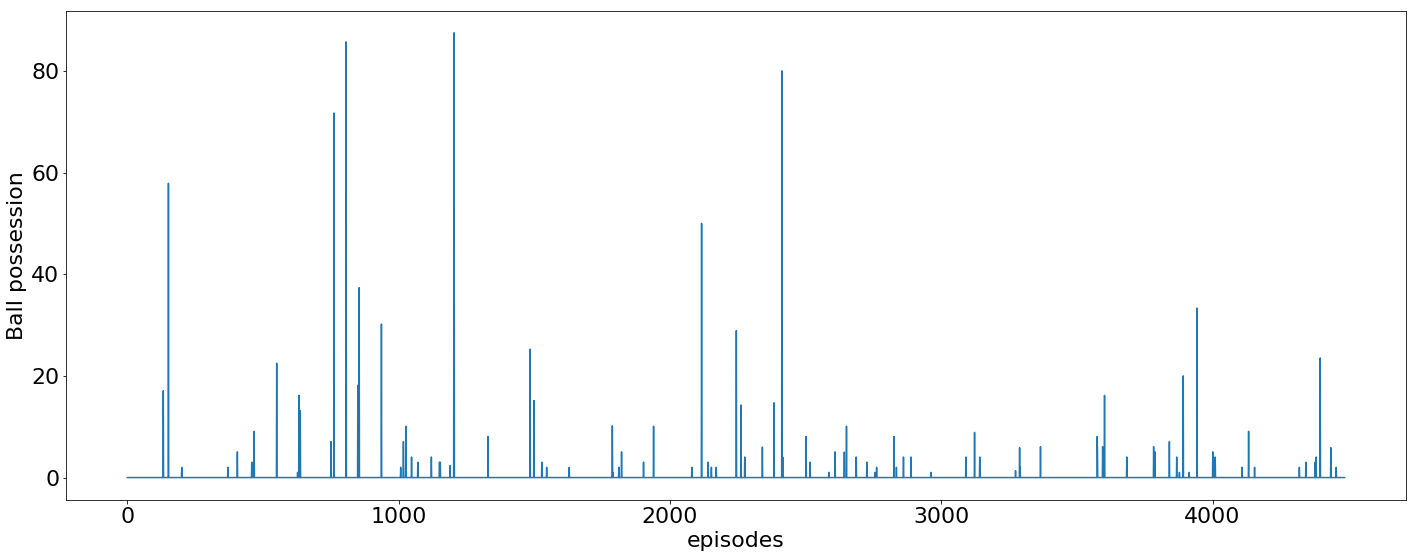

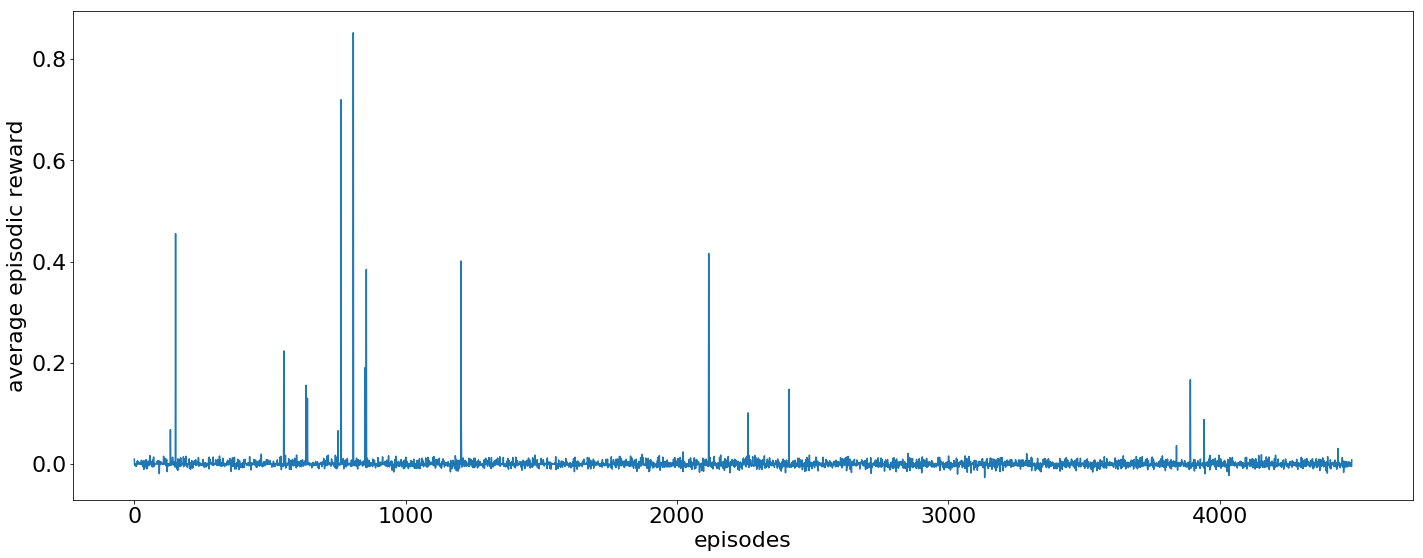

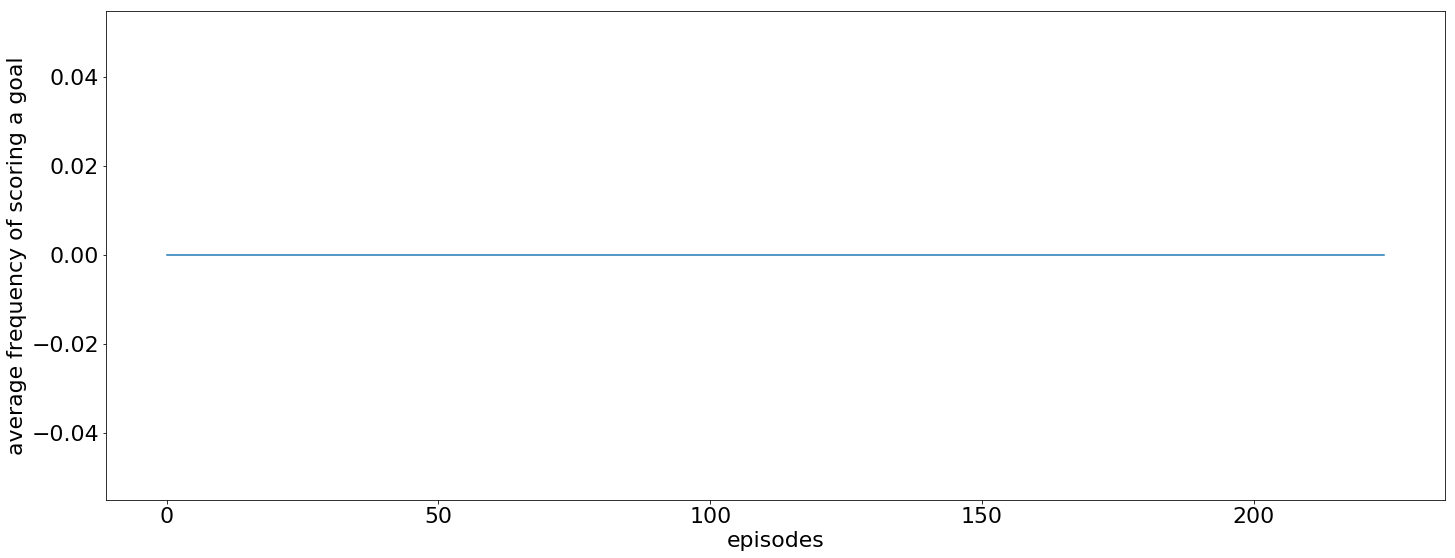

OutOfTime      4464
OutOfBounds      24
Name: why, dtype: int64

In [6]:
goal_frequency_window = 20

data = pd.read_csv('history.csv')

print('number of episodes finished %d'%len(data))

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(data.kickable_percentages)
plt.xlabel('episodes')
plt.ylabel('Ball possession')
plt.show()


reward = []
for i in range(len(data)):
    reward.append(literal_eval(data.average_reward[i]))
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(reward)
plt.xlabel('episodes')
plt.ylabel('average episodic reward')
plt.show()


goal_freq = []
for i in range(0, len(data), goal_frequency_window):
    temp = data.loc[i:i+goal_frequency_window].why.value_counts()
    
    try: 
        goal_freq.append(temp.Goal)
    except AttributeError:
        goal_freq.append(0)
        
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(goal_freq)
plt.xlabel('episodes')
plt.ylabel('average frequency of scoring a goal')
plt.show()
        
data.why.value_counts()